08/10/2023

The dataset analyzed in the notebook can be found in: https://www.kaggle.com/competitions/titanic

This assessment is made for the IBM Machine Learning Professional Certificate - Module 3 - SML Classification

Manuel del Angel Tena

In [1]:
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, FunctionTransformer, LabelEncoder
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.tree import plot_tree

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from imblearn.over_sampling import SMOTE


#model agnostic
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay


def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


# 1. Exploratory Data Analysis

## First analysis

In [2]:
gender = pd.read_csv("./titanic/gender_submission.csv")
test = pd.read_csv("./titanic/test.csv")
train = pd.read_csv("./titanic/train.csv")

The dataset cmpresses three different splits. One contains the training data, meanwhile the test contains a test split without the target class, which actually can be merged from "gender"

In [3]:
train.head(15)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


We can see 12 different features, here is a brief description of each:
 - survival	Survival	0 = No, 1 = Yes
 - pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
 - sex	Sex	
 - Age	Age in years	
 - sibsp	# of siblings / spouses aboard the Titanic	
 - parch	# of parents / children aboard the Titanic	
 - ticket	Ticket number	
 - fare	Passenger fare	
 - cabin	Cabin number	
 - embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


We have categorical and numerical features. It is worth noticing a huge number of null values for cabin, this should be addressed. On the other hand, there are a few age's don't specified. Finally, there are just two null values for Embarked.

In [5]:
train.drop("PassengerId", axis=1).describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


- A majority of passengers did notsurvived, as the average survival rate is approximately 38%, which is close to zero.
- Class 3 has more passengers than class 0.
- Approximately 50% of the passengers fall within the age range of 20 to 38, which is considered young. People above 52 are considered outliers, with a deviation of 75% or more from the standard.
- Most passengers typically had either 0 or 1 sibling on board.
- Normally, passengers had no parents on board, but having 1 parent on board is not considered an anomaly.
- Fares typically range from 32 to 49 euros. However, 50% of the data points are either 8 or 31 euros.


## Feature Engineering

One key point of this dataset relies on feature engineering since it will be seen that important information is hidden among different features. Feature engineering is going to be applied to the following features:

 - **Cabin information**: Depending on the cabin, the chances of survival when the Titanic sank appear to be different. In addition, there are a lot of null values, which could mean that the passenger did not have a cabin assigned.

 - **Tickets Exploration**: The tickets combine letters and numbers. They can be grouped by letters. It could be possible that depending on the place where the ticket was bought, the facilities are different, and so are the chances of surviving.

 - **Names and titles**: In the first exploration, it is seen that there are "Miss," "Mr.," and so on. It is widely known that "Mr." gave the boats to children and "Miss." Thus, this can be useful too.

 - **Age**: Must be analyzed to avoid losing a huge amount of data.

### Cabin information

Let's first look for the missing values in cabin

In [6]:
print(f"""
Cabin column has {train.Cabin.notna().sum()} not null values,
and {train.Cabin.nunique()} unique values, which are:
{train.Cabin.unique()}
""")


Cabin column has 204 not null values,
and 147 unique values, which are:
[nan 'C85' 'C123' 'E46' 'G6' 'C103' 'D56' 'A6' 'C23 C25 C27' 'B78' 'D33'
 'B30' 'C52' 'B28' 'C83' 'F33' 'F G73' 'E31' 'A5' 'D10 D12' 'D26' 'C110'
 'B58 B60' 'E101' 'F E69' 'D47' 'B86' 'F2' 'C2' 'E33' 'B19' 'A7' 'C49'
 'F4' 'A32' 'B4' 'B80' 'A31' 'D36' 'D15' 'C93' 'C78' 'D35' 'C87' 'B77'
 'E67' 'B94' 'C125' 'C99' 'C118' 'D7' 'A19' 'B49' 'D' 'C22 C26' 'C106'
 'C65' 'E36' 'C54' 'B57 B59 B63 B66' 'C7' 'E34' 'C32' 'B18' 'C124' 'C91'
 'E40' 'T' 'C128' 'D37' 'B35' 'E50' 'C82' 'B96 B98' 'E10' 'E44' 'A34'
 'C104' 'C111' 'C92' 'E38' 'D21' 'E12' 'E63' 'A14' 'B37' 'C30' 'D20' 'B79'
 'E25' 'D46' 'B73' 'C95' 'B38' 'B39' 'B22' 'C86' 'C70' 'A16' 'C101' 'C68'
 'A10' 'E68' 'B41' 'A20' 'D19' 'D50' 'D9' 'A23' 'B50' 'A26' 'D48' 'E58'
 'C126' 'B71' 'B51 B53 B55' 'D49' 'B5' 'B20' 'F G63' 'C62 C64' 'E24' 'C90'
 'C45' 'E8' 'B101' 'D45' 'C46' 'D30' 'E121' 'D11' 'E77' 'F38' 'B3' 'D6'
 'B82 B84' 'D17' 'A36' 'B102' 'B69' 'E49' 'C47' 'D28' 'E1

In [7]:
grouped_cnumber = train.groupby("Cabin").first().reset_index()
grouped_cnumber.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,147.000000,147.000000,147.000000,134.000000,147.000000,147.000000,147.000000
mean,424.285714,0.625850,1.142857,37.548507,0.353741,0.360544,74.481576
std,257.006529,0.485557,0.468165,15.309939,0.571021,0.651085,75.623053
min,2.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,213.000000,0.000000,1.000000,27.000000,0.000000,0.000000,30.000000
50%,430.000000,1.000000,1.000000,36.750000,0.000000,0.000000,53.100000
75%,654.000000,1.000000,1.000000,49.000000,1.000000,1.000000,83.316650
max,890.000000,1.000000,3.000000,80.000000,3.000000,2.000000,512.329200


Thanks to the describe method compressing the grouped dataset, it is seen that people with cabins is more likely to survive, thus will be an imporatent feature.

But depending on the cabin booked had passengers more chances to survive? Let's break it into Cabin Letters and Cabin Numbers.

In [8]:
train[['Cabin_Letter', 'Cabin_Number']] = train['Cabin'].str.extract(r'([A-Z]+)(\d+)')

In [9]:
train['Cabin_Letter'].value_counts()

Cabin_Letter
C    59
B    47
E    33
D    30
A    15
F     9
G     7
Name: count, dtype: int64

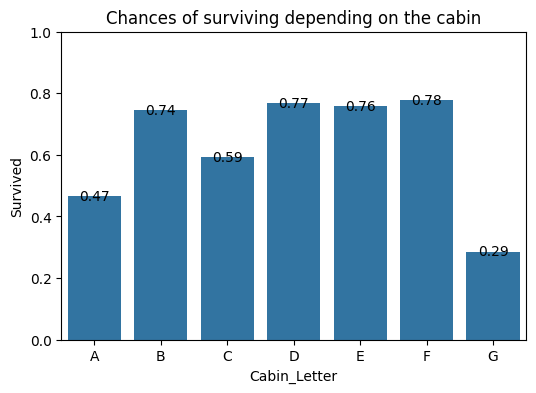

In [10]:
grouped_survived = train.groupby(['Cabin_Letter'])['Survived'].mean().reset_index()
grouped_value_counts = train.groupby(['Cabin_Letter'])['Cabin_Letter'].value_counts().reset_index()
grouped_cnumber = grouped_survived.merge(grouped_value_counts, on="Cabin_Letter")
grouped_cnumber.sort_values(by="Survived", ascending=False)

plt.figure(figsize=(6,4))
ax= sns.barplot(grouped_cnumber, x="Cabin_Letter", y="Survived")
plt.ylim((0, 1))
plt.title("Chances of surviving depending on the cabin")
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., 
                 p.get_height()), 
                ha='center', 
                va='center')

It is observed that the cabin letter plays an important role to predict whether or not a passanger has survived. Therefore it should be included as a feature in the dataset. But now let's see if the numbers also are significant.

Let's follow two strategies: 
1. Check per odds/even numbers
2. Check per tens

In [11]:
grouped_cnumber = train.groupby(['Cabin_Number'])['Survived'].mean().reset_index()
grouped_cnumber['Cabin_Number'] = grouped_cnumber['Cabin_Number'].astype(int)
grouped_cnumber =grouped_cnumber.sort_values(by='Cabin_Number')

grouped_cnumber['even/odd'] = grouped_cnumber.apply(lambda x: "even" if x['Cabin_Number'] % 2 == 0 else "odd", axis=1)
grouped_cnumber.head()

,Cabin_Number,Survived,even/odd
24,2,0.600000,even
33,3,1.000000,odd
44,4,1.000000,even
54,5,0.666667,odd
62,6,0.500000,even


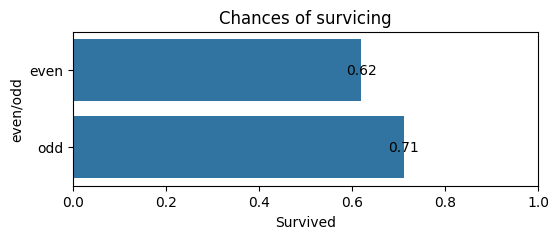

In [12]:
grouped_odd = grouped_cnumber.groupby("even/odd")['Survived'].mean()
grouped_odd

plt.figure(figsize=(6,2))
ax = sns.barplot(grouped_odd, orient="y")
plt.title("Chances of survicing")
plt.xlim(0,1)

for p in ax.patches:
    ax.annotate(f'{p.get_width():.2f}', 
                (p.get_width(), p.get_y() + p.get_height() / 2), 
                ha='center', va='center')

plt.show()


Finally, let's plot every single number to check the distribution.

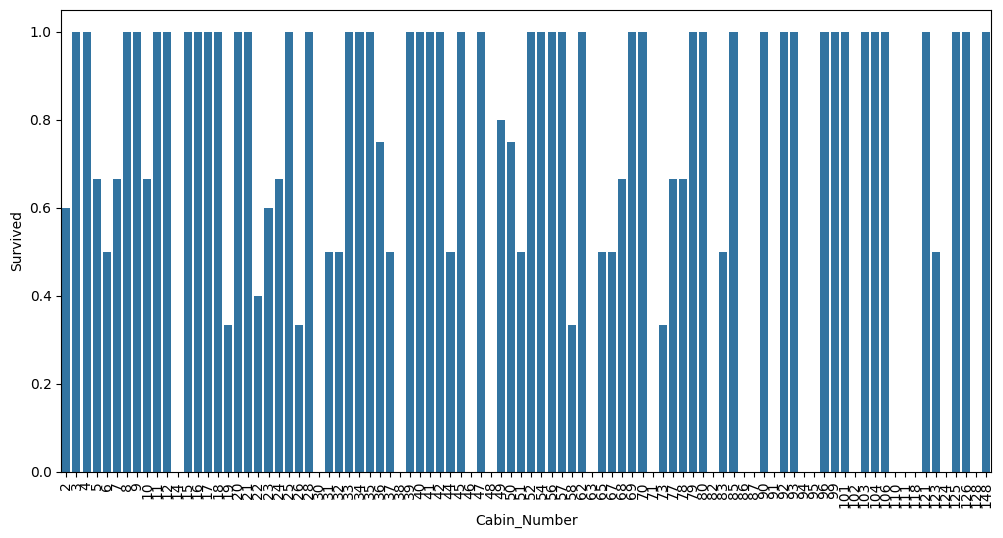

In [13]:
grouped_cnumber = grouped_cnumber.set_index(['Cabin_Number'])

plt.figure(figsize=(12, 6))
sns.barplot(grouped_cnumber['Survived'])
plt.xticks(rotation=90)
plt.show()

There are no patterns in the tens. Because of that, it can be concluded that the cabin should be added as a letter.

### Tickets exploration

In [14]:
train.Ticket.nunique()

681

There are 681 unique ticket values. However, from the data in the column, it appears that some tickets could belong to the same company. Some tickets have dots, while others do not. Let's implement the following strategy:

1. Remove dots in the entire column.
2. Remove "/".
3. Split the text by spaces.

In [15]:
train['Ticket'] = train['Ticket'].str.replace('[./]', 
                                              '', 
                                              regex=True)

train['Ticket_Company'] = train['Ticket'].str.extract(r'(\b[A-Z]+\d+|[A-Z]+\d+|[A-Z]+\b)')
train['Ticket_Number'] = train['Ticket'].str.extract(r'(\d+$)')

In [16]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_Letter,Cabin_Number,Ticket_Company,Ticket_Number
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A5 21171,7.2500,NaN,S,NaN,NaN,A5,21171
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C,85,PC,17599
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STONO2 3101282,7.9250,NaN,S,NaN,NaN,STONO2,3101282
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C,123,NaN,113803
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,NaN,NaN,NaN,373450


In [17]:
train.Ticket_Company.isnull().sum()

666

In [18]:
counts = train.Ticket_Company.value_counts().reset_index()
percentile_95 = counts['count'].quantile(0.85)
above_percentile_95 = counts[counts['count'] > percentile_95]
above_percentile_95 
columns95 = above_percentile_95.Ticket_Company.unique()

grouped_ticket = train.groupby("Ticket_Company")['Survived'].mean().reset_index()

grouped = grouped_ticket.merge(counts, on="Ticket_Company")
grouped = grouped[grouped['Ticket_Company'].isin(columns95)]

ticket_top = grouped.Ticket_Company.unique()
grouped


,Ticket_Company,Survived,count
1,A5,0.095238,21
4,CA,0.341463,41
9,PC,0.650000,60
21,SOTONOQ,0.133333,15
23,STONO,0.416667,12


The chances of surviving, depending on where the passenger bought a ticket, appear to be significant too

### Names and titles

Now it is time to analyze the names and the title of the passangers

In [19]:
train['Title'] = train['Name'].str.extract(r',\s(.*?)\.', expand=True)
grouped_count = train.groupby("Title")["Title"].value_counts().reset_index()
grouped_survived = train.groupby("Title")["Survived"].mean().reset_index()
grouped = grouped_count.merge(grouped_survived, on="Title")


In [20]:
grouped

,Title,count,Survived
0,Capt,1,0.000000
1,Col,2,0.500000
2,Don,1,0.000000
3,Dr,7,0.428571
4,Jonkheer,1,0.000000
5,Lady,1,1.000000
6,Major,2,0.500000
7,Master,40,0.575000
8,Miss,182,0.697802
9,Mlle,2,1.000000


We can see that despite we have multiple titles, most of them are minority classes. Because of that, we are going to keep only the most important ones.

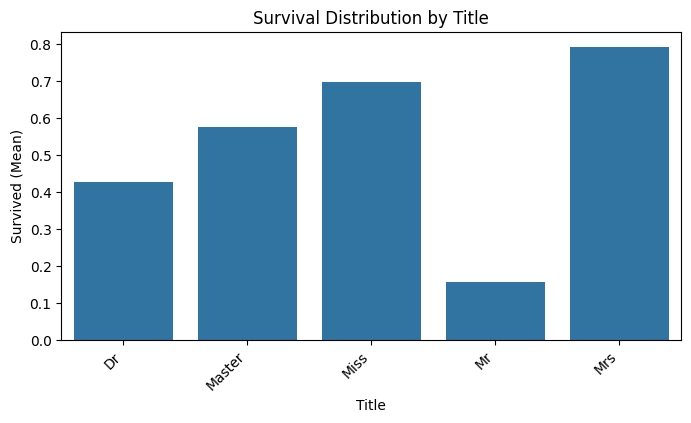

In [21]:
grouped = grouped[grouped['count'] > grouped['count'].quantile(0.7)]
top_title = grouped.Title.unique()
plt.figure(figsize=(8, 4))
sns.barplot(x='Title', y='Survived', data=grouped)
plt.title('Survival Distribution by Title')
plt.xlabel('Title')
plt.ylabel('Survived (Mean)')
plt.xticks(rotation=45, ha='right') 
plt.show()

It is seen that Mr has the less chances to survive, meanwhile Miss and Mrs the most

### Age distribution

The null values for age must be handled.

In [22]:
train_null_age = train.Age.isna()
train[train_null_age].describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,177.000000,177.000000,177.000000,0.0,177.000000,177.000000,177.000000
mean,435.581921,0.293785,2.598870,NaN,0.564972,0.180791,22.158567
std,250.552901,0.456787,0.763216,NaN,1.626316,0.534145,31.874608
min,6.000000,0.000000,1.000000,NaN,0.000000,0.000000,0.000000
25%,230.000000,0.000000,3.000000,NaN,0.000000,0.000000,7.750000
50%,452.000000,0.000000,3.000000,NaN,0.000000,0.000000,8.050000
75%,634.000000,1.000000,3.000000,NaN,0.000000,0.000000,24.150000
max,889.000000,1.000000,3.000000,NaN,8.000000,2.000000,227.525000


There is no evidence of a hidden pattern in those passangers who actually don't have an Age assigned. One common practise to handle this situation is to compute and assign the median or mean value of the age. 

However, this is not a good practice for our case. This is because we have more information that can help describe age more accurately. For example, if the passenger has parents on board, they would tend to be younger, while if they are in the lowest age category, they will tend to be even younger.

In [23]:
grouped_ages = train.groupby(['Pclass', 'SibSp', 'Parch', 'Title'])['Age'].mean().reset_index()
grouped_ages.head(10)


,Pclass,SibSp,Parch,Title,Age
0,1,0,0,Col,58.000000
1,1,0,0,Don,40.000000
2,1,0,0,Dr,40.500000
3,1,0,0,Jonkheer,38.000000
4,1,0,0,Major,48.500000
5,1,0,0,Miss,33.750000
6,1,0,0,Mlle,24.000000
7,1,0,0,Mme,24.000000
8,1,0,0,Mr,44.372340
9,1,0,0,Mrs,51.333333


<Axes: xlabel='Age', ylabel='Count'>

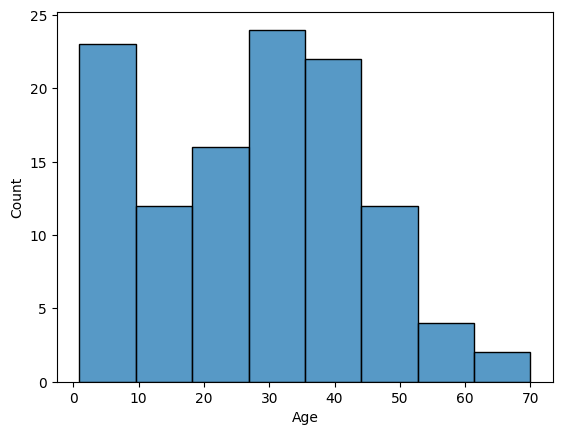

In [24]:
sns.histplot(grouped_ages['Age'])

To achieve that, the mean of each group can be computed, and then the same group with null age can be identified with the new age inserted.

In [25]:
train['Age'] = train['Age'].fillna(train.groupby(['Pclass', 'Sex', 'SibSp', 'Parch', 'Title'])['Age'].transform('mean'))
train['Age'] = train['Age'].fillna(train.groupby(['Pclass', 'Parch'])['Age'].transform('mean'))

train.Age.isnull().sum()

0

### Feature creation

In [26]:
train["alone"] = train.apply(lambda row: 1 if (row["SibSp"] == 0) & (row["Parch"] == 0) else 0, axis=1)

## Visualizations

Is there a correlation between the departure port and the chances of surviving?

<Axes: xlabel='Pclass', ylabel='count'>

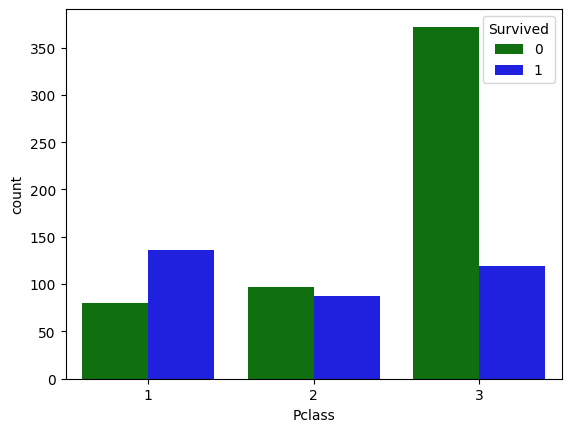

In [27]:
sns.countplot(data=train, x="Pclass", hue="Survived", palette= ["green", "blue"])

Passengers from class 1 and 2 have more chances to survive

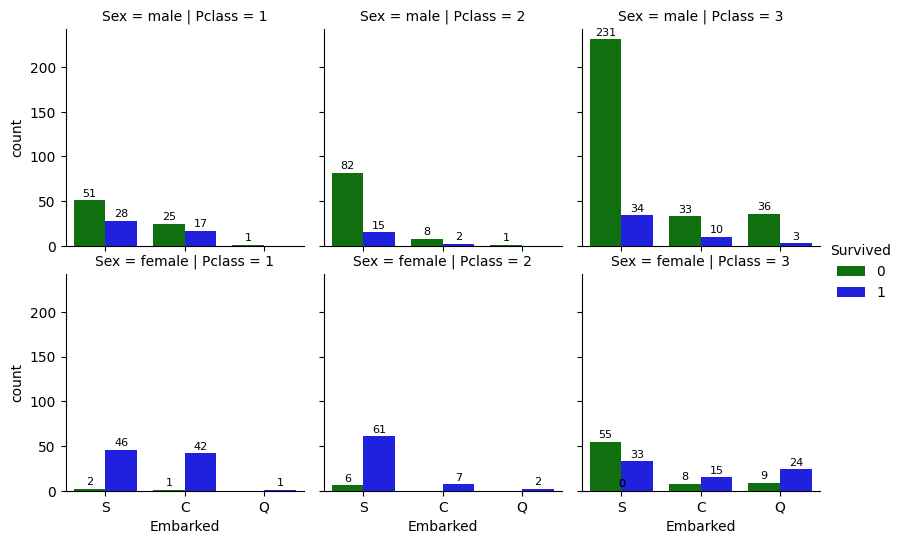

In [28]:
g = sns.catplot(data=train, 
            x="Embarked", 
            hue="Survived", 
            col="Pclass",
            row="Sex",  
            kind="count",
            palette=["green", "blue"],
            height=4, 
            aspect=0.7)


for ax in g.axes.flat:
    for p in ax.patches:
        ax.annotate(int(p.get_height()), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', fontsize=8, xytext=(0, 5), textcoords='offset points')

plt.subplots_adjust(top=0.65)
plt.show()

 - The survival rate for women embarking from S and C, belonging to class 1, is very high.
 - The survival rate for men is higher if they embarked from C.


# 2. Dataset preparation

The strategy to prepare a dataset to fit the model is the following one:

1. Drop unnecessary columns
2. Set all the categories as a features. It is important to remember that there were too many titles, some of them with only one representation. Therefore, these sparsely represented categories should not be considered as features, whereas those with high occurrences should be. As a result, we are removing everything that is not within the top 10% quantile of representation

In [29]:
train = train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Cabin_Number', 'Ticket_Number'], axis=1)
train["Title"] = train.apply(lambda x: x['Title'] if x['Title'] in top_title else np.nan, axis=1)
train["Ticket_Company"] = train.apply(lambda x: x['Ticket_Company'] if x['Ticket_Company'] in ticket_top else np.nan, axis=1)
categorical_features = ['Sex', 'Embarked', 'Title', "Cabin_Letter", "Ticket_Company"]
train = pd.get_dummies(train, columns=categorical_features, dtype=int)

Text(0.5, 1.0, 'Correlation Matrix')

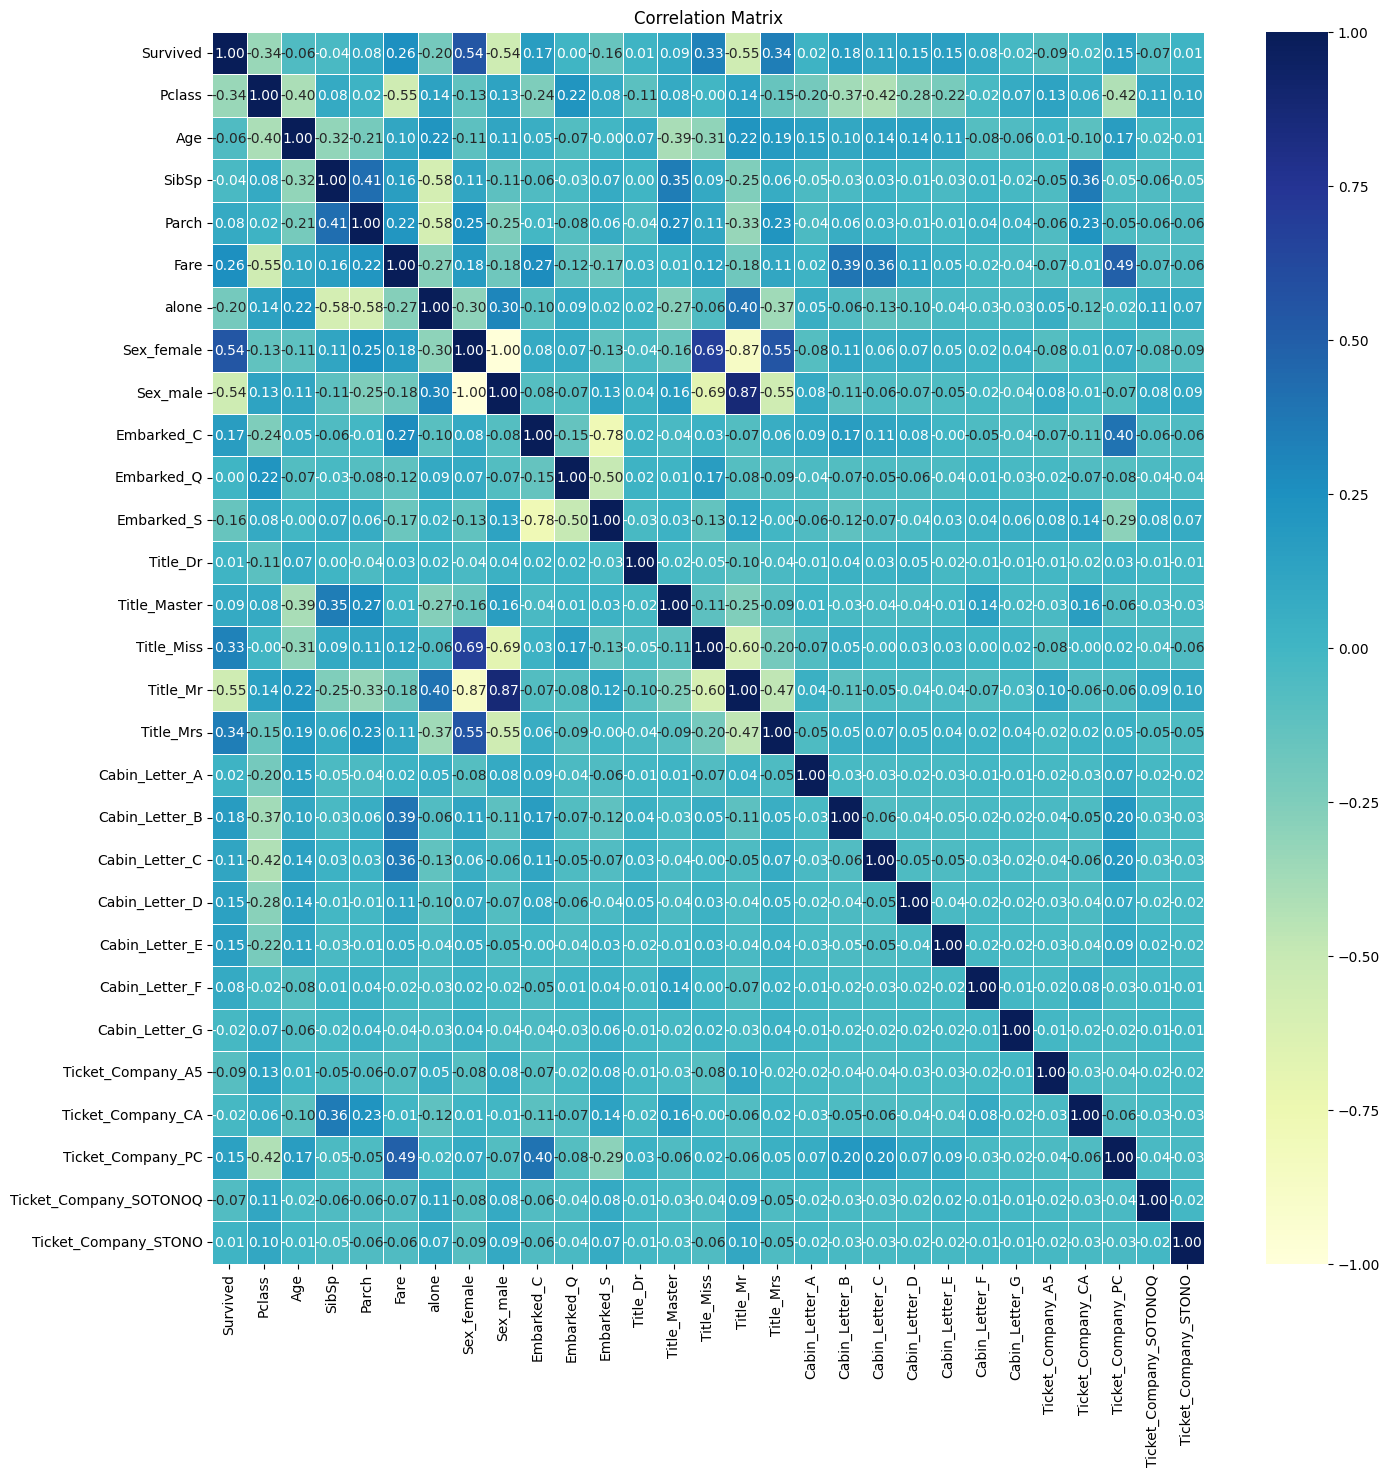

In [30]:
correlation_matrix = train.corr()

plt.figure(figsize=(16, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")

There are only high correlations between being male and the title of mister and being female and the title of miss.

In [31]:
train

,Survived,Pclass,Age,SibSp,Parch,Fare,alone,Sex_female,Sex_male,Embarked_C,...,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,Ticket_Company_A5,Ticket_Company_CA,Ticket_Company_PC,Ticket_Company_SOTONOQ,Ticket_Company_STONO
0,0,3,22.0,1,0,7.2500,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,1,1,38.0,1,0,71.2833,0,1,0,1,...,1,0,0,0,0,0,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,35.0,1,0,53.1000,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,3,35.0,0,0,8.0500,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.0,0,0,13.0000,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
887,1,1,19.0,0,0,30.0000,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
888,0,3,13.6,1,2,23.4500,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
889,1,1,26.0,0,0,30.0000,1,0,1,1,...,1,0,0,0,0,0,0,0,0,0


Let's perform now the train test split

In [92]:

X = train.drop("Survived", axis=1)
y= train['Survived']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    # random_state=42,
                                                    stratify = y)


#numericals
numerical_features = ["Age", "SibSp", "Parch", "Fare"]
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# 3. Modelling support functions

This section defines different functions that will be used later on by the models to get results or interpretability.

In [33]:
def measure_error(y_true, y_pred):
    return pd.Series({'accuracy':accuracy_score(y_true, y_pred),
                      'precision': precision_score(y_true, y_pred),
                      'recall': recall_score(y_true, y_pred),
                      'f1': f1_score(y_true, y_pred)})

Permutation importance, shuffles the values of a feature and measures the impact on the model's performance.
if a feature is important, shuffling its values will cause the model's performance to decrease significantly.

In [34]:
def get_PermutationImportance(model, X_train, y_train):
    feature_importances = permutation_importance(estimator=model, 
                                             X=X_train, 
                                             y=y_train, 
                                             n_repeats=10,
                                             n_jobs=2)
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=feature_importances.importances.T, 
            orient="h",
            width=0.5)
    plt.xlabel("Category")
    plt.yticks(range(len(X_train.columns)), X_train.columns)
    plt.title("Permutation importance")
    plt.show()

Partial dependence displays are a way to visually and quantitatively understand the relationship between a feature and the predicted value of the model, while changing all other features. 

In [35]:
def get_PartialDependenceDisplay(model, X_train, feature):
    PartialDependenceDisplay.from_estimator(estimator=model, 
                            X=X_train, 
                            features=[feature],
                            random_state=123)

Classification report gives back Precision Recall and f1 for each label.

In [36]:
def get_ClassificationReport(y_true, y_pred):
    print(classification_report(y_true, y_pred))

# 4. Models 

## 4.1 Decision tree

In [93]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

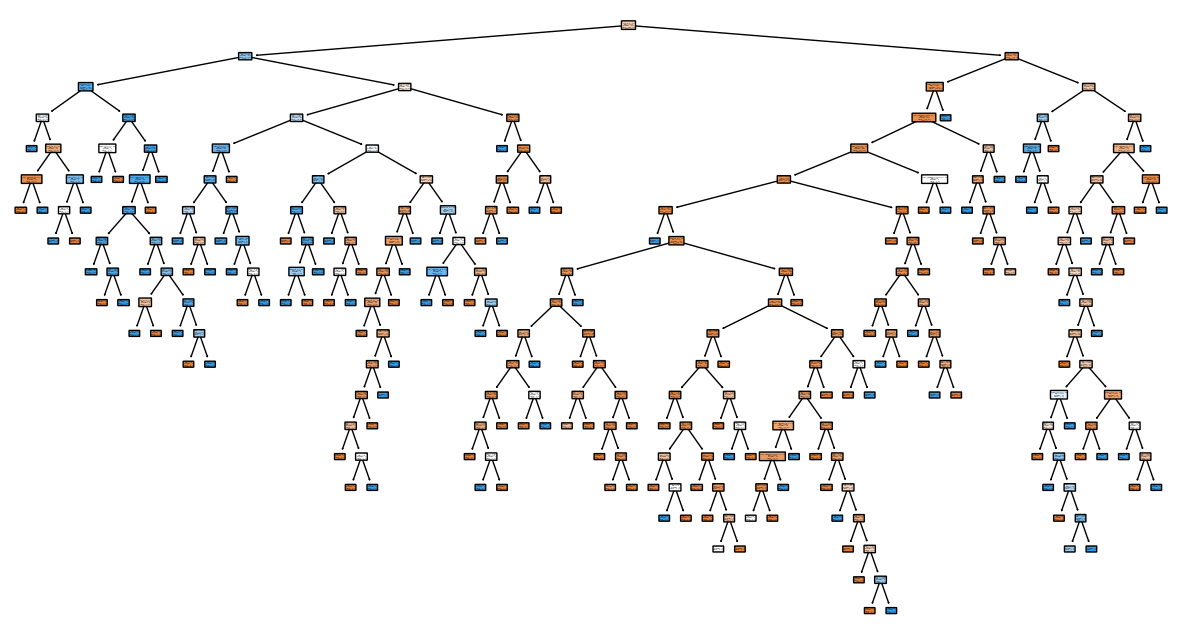

In [94]:
plt.figure(figsize=(15, 8))
plot_tree(dt, filled=True, feature_names=X_train.columns, class_names=[str(i) for i in dt.classes_], rounded=True)
plt.show()

In [95]:
measure_error(y_test, y_pred)

accuracy     0.794776
precision    0.735294
recall       0.728155
f1           0.731707
dtype: float64

Let's tune some parameters:
1. max_depth: Maximum depth allowed to grow. For large depth values it tends to overfit.
2. min_sample_split: 

In [96]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'max_features': ['auto', 'sqrt', 'log2']
}

GR = GridSearchCV(dt, param_grid=param_grid, scoring='accuracy', n_jobs=-1)
GR = GR.fit(X_train, y_train)

best_params = GR.best_params_
best_estimator = GR.best_estimator_

y_pred = best_estimator.predict(X_test)

In [97]:
measure_error(y_test, y_pred)

accuracy     0.828358
precision    0.800000
recall       0.737864
f1           0.767677
dtype: float64

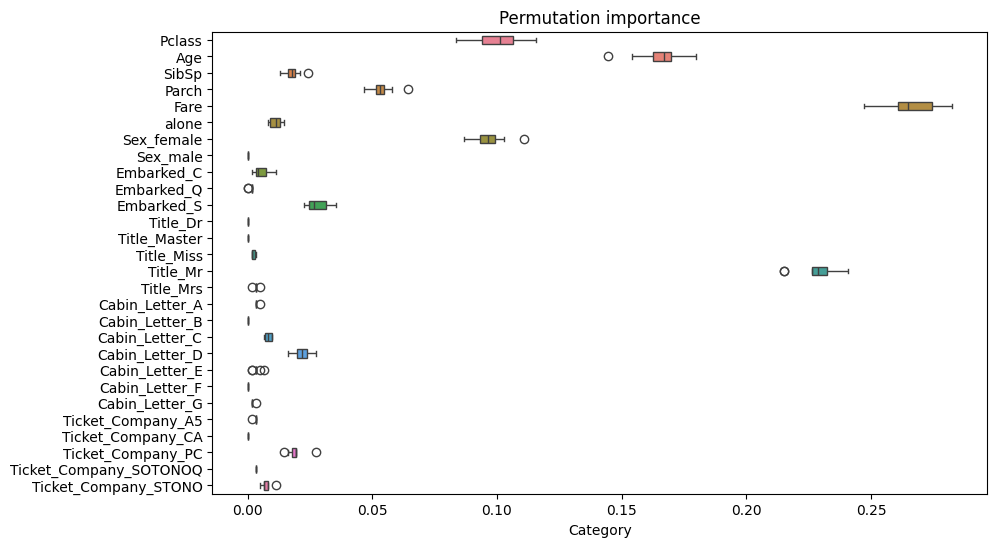

In [98]:
get_PermutationImportance(dt, X_train, y_train)

## 4.2 Random Forest

Random forests are a combination of trees such that each tree depends on a random subset of the features and data. As a result, each tree in the forest is different and usually performs better than Bagging. Like Bagging, increasing the number of trees improves results and does not lead to overfitting in most cases; but the improvements plateau as you add more trees. 

If we have M features, a popular method to determine m is to use the square root of M

In [99]:
n_estimators=20
M_features=X.shape[1]
max_features=round(np.sqrt(M_features))-1

In [100]:
rf = RandomForestClassifier( max_features=max_features,
                            n_estimators=n_estimators)

In [101]:
cross_val_score(rf, X_train, y_train, cv=5)

array([0.8       , 0.776     , 0.8       , 0.80645161, 0.80645161])

In [102]:
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

In [103]:
measure_error(y_test, y_pred)

accuracy     0.820896
precision    0.777778
recall       0.747573
f1           0.762376
dtype: float64

In [104]:
get_ClassificationReport(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.85      0.87      0.86       165
           1       0.78      0.75      0.76       103

    accuracy                           0.82       268
   macro avg       0.81      0.81      0.81       268
weighted avg       0.82      0.82      0.82       268



## 4.3 Boosting

Parameters: 
- Learning rate, is a value between 0 and 1 that controls the contribution of each model into the final ensambling. A smaller learning rate puts more emphasis on the contribution of the weak model, allowing the model to learn more slowly and potentially lead to better generalization.


In [105]:
error_list = list()

tree_list = [15, 25, 50, 100, 200, 400, 800, 1200, 4000]
data=pd.DataFrame()

for tree in tree_list:
    print("Fitting a boosting with trees: ", tree)
    clf = GradientBoostingClassifier(n_estimators=tree, 
                                 learning_rate=0.3,
                                 max_depth=1, 
                                 random_state=0).fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    results = measure_error(y_test, y_pred)
    # get_ClassificationReport(y_test, y_pred)
    
    data[tree] = results
    

Fitting a boosting with trees:  15
Fitting a boosting with trees:  25
Fitting a boosting with trees:  50
Fitting a boosting with trees:  100
Fitting a boosting with trees:  200
Fitting a boosting with trees:  400
Fitting a boosting with trees:  800
Fitting a boosting with trees:  1200
Fitting a boosting with trees:  4000


In [106]:
data

,15,25,50,100,200,400,800,1200,4000
accuracy,0.809701,0.828358,0.835821,0.832090,0.828358,0.835821,0.839552,0.839552,0.828358
precision,0.765306,0.806452,0.797980,0.795918,0.776699,0.804124,0.794118,0.800000,0.800000
recall,0.728155,0.728155,0.766990,0.757282,0.776699,0.757282,0.786408,0.776699,0.737864
f1,0.746269,0.765306,0.782178,0.776119,0.776699,0.780000,0.790244,0.788177,0.767677


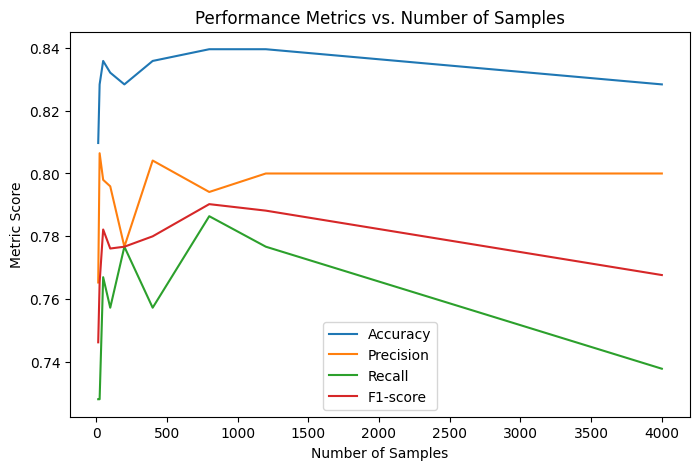

In [107]:
data = data.T

plt.figure(figsize=(8,5))
plt.plot(data.index, data.accuracy, label='Accuracy')
plt.plot(data.index, data.precision, label='Precision')
plt.plot(data.index, data.recall, label='Recall')
plt.plot(data.index, data.f1, label='F1-score')
plt.legend()
plt.title('Performance Metrics vs. Number of Samples')
plt.xlabel('Number of Samples')
plt.ylabel('Metric Score')
plt.show()

In [108]:
tree_list = [15, 25, 100, 200, 400, 1000]

In [109]:
param_grid = {'n_estimators': tree_list,
              'learning_rate': [0.1, 0.01, 0.001, 0.0001],
              'subsample': [1.0, 0.5],
              'max_features': [1, 2, 3, 4]}

# The grid search object
GV_GBC = GridSearchCV(GradientBoostingClassifier(random_state=42), 
                      param_grid=param_grid, 
                      scoring='accuracy',
                      n_jobs=-1)

# Do the grid search
GV_GBC = GV_GBC.fit(X_train, y_train)

In [110]:
y_pred = GV_GBC.predict(X_test)
get_ClassificationReport(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.86      0.91      0.88       165
           1       0.84      0.76      0.80       103

    accuracy                           0.85       268
   macro avg       0.85      0.83      0.84       268
weighted avg       0.85      0.85      0.85       268



In [111]:
feature_importances = clf.feature_importances_
feature_names = X_train.columns

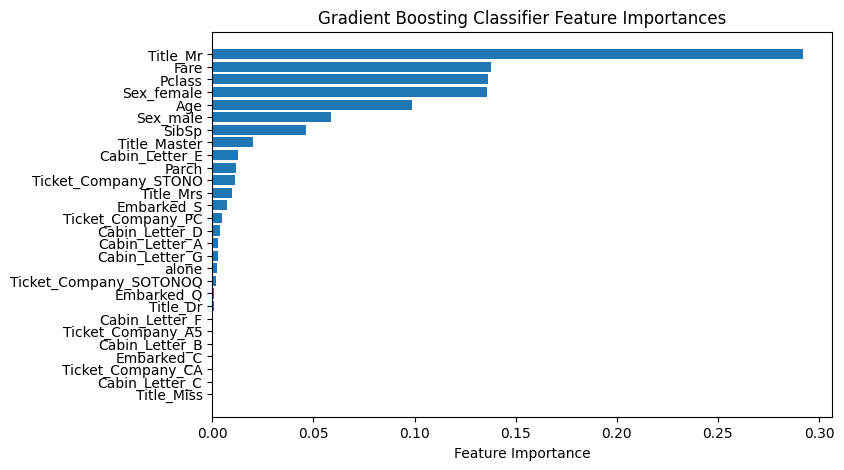

In [112]:
sorted_indices = np.argsort(feature_importances)


plt.figure(figsize=(8, 5))
plt.barh(range(len(feature_importances)), feature_importances[sorted_indices], align='center')
plt.yticks(range(len(feature_importances)), [feature_names[i] for i in sorted_indices])
plt.xlabel('Feature Importance')
plt.title('Gradient Boosting Classifier Feature Importances')
plt.show()

## 4.4 Last Model (Stacking) - RF + Boosting

Stacking is an ensemble machine learning technique that combines multiple base models to improve predictive performance. 

In stacking, you are training multiple models, they can be different, and then the predictions of one model are used as an inputs of another model named the blender. This blender model, is trained to make predictions based on the predictions of the base models, so it learns how to weight effectively and combine predictions to make a final one.

But first, let's generate synthetic data to mitigate the oversampling

In [57]:
train.Survived.value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

Now we are going ot oversample the minority class

In [58]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [113]:
rf = RandomForestClassifier( max_features=max_features,
                            n_estimators=n_estimators)
rf.fit(X_train_resampled, y_train_resampled)
y_pred = rf.predict(X_test)

In [114]:
get_ClassificationReport(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.89      0.88      0.89       165
           1       0.82      0.83      0.82       103

    accuracy                           0.86       268
   macro avg       0.85      0.86      0.85       268
weighted avg       0.86      0.86      0.86       268



In [116]:
measure_error(y_test, y_pred)

accuracy     0.861940
precision    0.817308
recall       0.825243
f1           0.821256
dtype: float64

and then train a Boosting ensemble model

In [117]:
param_grid = {'n_estimators': [15, 50, 100, 200, 400, 800],
              'learning_rate': [0.1, 0.01, 0.001, 0.0001],
              'subsample': [1.0, 0.5],
              'max_features': [1, 2, 3, 4]}

# The grid search object
GV_GBC = GridSearchCV(GradientBoostingClassifier(random_state=42), 
                      param_grid=param_grid, 
                      scoring='accuracy',
                      n_jobs=-1)

# Do the grid search
GV_GBC = GV_GBC.fit(X_train_resampled, y_train_resampled)

In [118]:
y_pred = GV_GBC.predict(X_test)

In [119]:
get_ClassificationReport(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.91      0.87      0.89       165
           1       0.81      0.86      0.84       103

    accuracy                           0.87       268
   macro avg       0.86      0.87      0.86       268
weighted avg       0.87      0.87      0.87       268



Now, we are adding the Voting Classifier.

A VotingClassifier combines the predictions of multiple base classifiers by allowing them to "vote" on the final predicted class for a given input sample. The class with the most votes becomes the final prediction. VotingClassifier supports two types of voting:

Hard Voting: In hard voting, each base classifier makes a prediction, and the class that receives the majority of votes is chosen as the final prediction.

Soft Voting: In soft voting, each base classifier provides class probabilities for each class, and the final prediction is made by averaging these probabilities across the base classifiers and selecting the class with the highest average probability.

In [120]:
from sklearn.ensemble import VotingClassifier

estimators = [('rf', rf), ('GBC', GV_GBC)]

VC = VotingClassifier(estimators, voting='soft')
VC = VC.fit(X_train_resampled, y_train_resampled)

y_pred = VC.predict(X_test)

In [121]:
get_ClassificationReport(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.92      0.87      0.89       165
           1       0.81      0.87      0.84       103

    accuracy                           0.87       268
   macro avg       0.86      0.87      0.87       268
weighted avg       0.88      0.87      0.87       268



In [122]:
measure_error(y_test, y_pred)

accuracy     0.873134
precision    0.810811
recall       0.873786
f1           0.841121
dtype: float64

# Test dataset

In [183]:
test = pd.read_csv("./titanic/test.csv")

In [184]:
test = test.merge(gender, on = "PassengerId")

In [185]:

test[['Cabin_Letter', 'Cabin_Number']] = test['Cabin'].str.extract(r'([A-Z]+)(\d+)')

test['Ticket'] = test['Ticket'].str.replace('[./]', 
                                              '', 
                                              regex=True)

test['Ticket_Company'] = test['Ticket'].str.extract(r'(\b[A-Z]+\d+|[A-Z]+\d+|[A-Z]+\b)')
test['Ticket_Number'] = test['Ticket'].str.extract(r'(\d+$)')

test["alone"] = test.apply(lambda row: 1 if (row["SibSp"] == 0) & (row["Parch"] == 0) else 0, axis=1)

test['Title'] = test['Name'].str.extract(r',\s(.*?)\.', expand=True)
test['Age'] = test['Age'].fillna(test.groupby(['Pclass', 'Sex', 'SibSp', 'Parch', 'Title'])['Age'].transform('mean'))
test['Age'] = test['Age'].fillna(test.groupby(['Pclass', 'Parch'])['Age'].transform('mean'))
test['Age'] = test['Age'].fillna(test['Age'].mean())
test['Fare'] = test['Fare'].fillna(test['Fare'].mean())


test= test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Cabin_Number', 'Ticket_Number'], axis=1)
test["Title"] = test.apply(lambda x: x['Title'] if x['Title'] in top_title else np.nan, axis=1)
test["Ticket_Company"] = test.apply(lambda x: x['Ticket_Company'] if x['Ticket_Company'] in ticket_top else np.nan, axis=1)
categorical_features = ['Sex', 'Embarked', 'Title', "Cabin_Letter", "Ticket_Company"]
test = pd.get_dummies(test, columns=categorical_features, dtype=int)

test

,Pclass,Age,SibSp,Parch,Fare,Survived,alone,Sex_female,Sex_male,Embarked_C,...,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,Ticket_Company_A5,Ticket_Company_CA,Ticket_Company_PC,Ticket_Company_SOTONOQ,Ticket_Company_STONO
0,3,34.500000,0,0,7.8292,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,3,47.000000,1,0,7.0000,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,62.000000,0,0,9.6875,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,3,27.000000,0,0,8.6625,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,3,22.000000,1,1,12.2875,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,3,26.594203,0,0,8.0500,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
414,1,39.000000,0,0,108.9000,1,1,1,0,1,...,1,0,0,0,0,0,0,1,0,0
415,3,38.500000,0,0,7.2500,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
416,3,26.594203,0,0,8.0500,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [186]:
X_train = train.drop("Survived", axis=1)
y_train =train["Survived"]
X_test = test.drop("Survived", axis=1)
y_test =test["Survived"]

In [187]:
numerical_features = ["Age", "SibSp", "Parch", "Fare"]
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

In [168]:
train.Survived.value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

Now we are going ot oversample the minority class

In [169]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

and then train a Boosting ensemble model

In [188]:
param_grid = {'n_estimators': [15, 50, 100, 200, 400, 800],
              'learning_rate': [0.1, 0.01, 0.001, 0.0001],
              'subsample': [1.0, 0.5],
              'max_features': [1, 2, 3, 4]}

# The grid search object
GV_GBC = GridSearchCV(GradientBoostingClassifier(random_state=42), 
                      param_grid=param_grid, 
                      scoring='accuracy',
                      n_jobs=-1)

# Do the grid search
GV_GBC = GV_GBC.fit(X_train, y_train)

In [189]:
y_pred = GV_GBC.predict(X_test)

In [190]:
get_ClassificationReport(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.88      0.85      0.86       266
           1       0.75      0.80      0.77       152

    accuracy                           0.83       418
   macro avg       0.81      0.82      0.82       418
weighted avg       0.83      0.83      0.83       418



In [191]:
rf = RandomForestClassifier( max_features=max_features,
                            n_estimators=n_estimators)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

get_ClassificationReport(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       266
           1       0.74      0.74      0.74       152

    accuracy                           0.81       418
   macro avg       0.79      0.79      0.79       418
weighted avg       0.81      0.81      0.81       418



In [194]:
from sklearn.ensemble import VotingClassifier

estimators = [('rf', rf), ('GBC', GV_GBC)]

VC = VotingClassifier(estimators, voting='soft')
VC = VC.fit(X_train, y_train)

y_pred = VC.predict(X_test)

In [195]:
get_ClassificationReport(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.88      0.85      0.86       266
           1       0.75      0.79      0.77       152

    accuracy                           0.83       418
   macro avg       0.81      0.82      0.82       418
weighted avg       0.83      0.83      0.83       418



In [196]:
measure_error(y_test, y_pred)

accuracy     0.827751
precision    0.750000
recall       0.789474
f1           0.769231
dtype: float64